<a href="https://colab.research.google.com/github/Jenny-Zhu/WiFiSSL/blob/main/HM3_0_DL_self_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up Environment

In [ ]:
%%capture
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import torch
from torch.utils.data import Dataset, DataLoader,random_split
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import pdb
import h5py as h5
!pip install einops
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sn
import random
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
import time
from torch.optim.lr_scheduler import LambdaLR
import copy
!pip install mat73
import mat73
from torch.optim import lr_scheduler
import argparse

# Start by connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/drive')

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

# Data Loader

In [ ]:
def generate_labels(task,file_name):
  """ generate the class label based on the filename for different task

  Parameters
  ----------
  task: str
    The classification task. Should be one value in ['HumanNonhuman', 'FourClass', 'HumanID', 'HumanMotion']
  file_name: str
    The filename that store the data for certain class

  Returns
  ----------
  label: int
    the result encoded class label

  """
  assert isinstance(task, str)
  assert isinstance(file_name, str)
  assert task in ['HumanNonhuman', 'FourClass', 'HumanID', 'HumanMotion','ThreeClass']


  if task == 'HumanNonhuman':
    if 'Human' in file_name:
      label = 1
      print('Human labeled')
      print(label)
    else:
      label = 0
      print('Nonhuman labeled')
      print(label)

  elif task == 'FourClass':


    # Define the labels
    label_dict = {'Human': 0, 'Pet': 1, 'IRobot':2, 'Fan':3}

    if 'Human' in file_name:
        label=label_dict['Human']
        print('Human labeled')
    elif 'Pet' in file_name:
        label=label_dict['Pet']
        print('Pet labeled')
    elif 'IRobot' in file_name:
        label=label_dict['IRobot']
        print('IRobot labeled')
    elif 'Fan' in file_name:
        label=label_dict['Fan']
        print('Fan labeled')
        print(label)
    else:
      print('Unrecognize class type for  ' +file_name )

  elif task == 'ThreeClass':
    # Define the labels
    label_dict = {'Human': 0, 'Pet': 1, 'IRobot':2}

    if 'Human' in file_name:
        label=label_dict['Human']
        print('Human labeled')
    elif 'Pet' in file_name:
        label=label_dict['Pet']
        print('Pet labeled')
    elif 'IRobot' in file_name:
        label=label_dict['IRobot']
        print('IRobot labeled')
    else:
      print('Unrecognize class type for  ' +file_name )

  elif task == 'HumanID':
    tester_list = ['Andrew', 'Brain','Brendon','Dan']
    for ind,val in enumerate(tester_list):
      if val in file_name:
        label = ind+1
        break
    print('Unrecognize class type for  ' +file_name )

  elif task == 'HumanMotion':
    motion_list = ['Running','Sneaking','Walking']
    for ind,val in enumerate(motion_list):
      if val in file_name:
        label = ind+1
        break

    print('Unrecognize class type for  ' +file_name )

  else:
    pass
  return label

In [ ]:
class OW_dataset_class(Dataset):
    def __init__(self, data_dir, task,  experiment, if_test,test_data):
        self.samples = []
        self.labels = []

        # find the corresponding data directory
        if task == 'HumanNonhuman':
            root_dir = data_dir + "/OW_HumanNonhuman/"+ experiment+"/"
        elif task == 'FourClass':
            root_dir = data_dir + "/OW_HumanNonhuman/"+ experiment+"/"
        elif task == 'ThreeClass':
            root_dir = data_dir + "/OW_HumanNonhuman/"+ experiment+"/"
        elif task == 'HumanID':
            root_dir = data_dir + '/OW_HumanID/'
        elif task == 'HumanMotion':
            root_dir = data_dir + '/OW_HAR/'

        folder_name = os.path.join(root_dir, 'train/')
        if if_test:
          if test_data == 1:
            folder_name = os.path.join(root_dir, 'test/')
          elif test_data == 2:
            folder_name = os.path.join(root_dir, 'ssl/')


        file_list = os.listdir(folder_name)

        if test_data ==2:
          file_list = file_list+ [i for i in file_list if i.endswith('5_half_whole.mat')]
        else:
          file_list = [i for i in file_list if i.endswith('5_half.mat')]

        file_list  = [ x for x in file_list if "Dan" not in x ]
        # load python preprocessed .npz file
        # file_list = [i for i in file_list if i.endswith('.npz')]
        if task == 'ThreeClass':
          file_list  = [ x for x in file_list if "Fan" not in x ]
        for file_path in file_list:
            samples = mat73.loadmat(os.path.join(folder_name, file_path))['X']
            # samples = samples.transpose((0,2,1))
            # if the file list end with .npz, use np.load
            # samples = np.load(os.path.join(folder_name, file_path))['arr_0']
            samples_tensor = torch.from_numpy(samples).float()
            self.samples.append(samples_tensor)
            label = generate_labels(task, file_path)
            for i in range(samples_tensor.shape[0]):
              self.labels.append(label)



        # self.samples = torch.stack(self.samples, dim=0)
        self.samples = torch.unsqueeze(torch.cat(self.samples, dim=0),dim=-3)


    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, index):
        return self.samples[index], self.labels[index]

# Models

## MLP


In [ ]:
class OW_MLP(nn.Module):

  """
    A class to store the Multi-layer perceptron model
    ...

    Attributes
    ----------
    class_num:int
      the number of classes for training models

    Methods
    -------
    forward(x)
      computes output Tensors from input Tensors.

  """
  def __init__(self,class_num,win_len,feature_size):

    super(OW_MLP,self).__init__()
    self.fc = nn.Sequential(
      nn.Linear(win_len*feature_size,1024),
      nn.ReLU(),
      nn.Linear(1024,128),
      nn.ReLU(),
      nn.Linear(128,class_num)
    )

  def forward(self,x):
    x = x.view(-1,win_len*feature_size)
    x = self.fc(x)
    return x



## MLP Parallel

In [ ]:
class MLP_Parrallel(nn.Module):
    def __init__(self,class_num,win_len,feature_size):
        super(MLP_Parrallel, self).__init__()
        self.encoder_1 = MLP_encoder(win_len,feature_size)
        self.encoder_2 = MLP_encoder(win_len,feature_size)

        self.classifier = nn.Linear(128,class_num)

    def forward(self, x1, x2, flag='unsupervised'):
        if flag == 'supervised':
            x1 = self.encoder_1(x1, flag=flag)
            x2 = self.encoder_2(x2, flag=flag)
            y1 = self.classifier(x1)
            y2 = self.classifier(x2)
            return y1, y2
        x1 = self.encoder_1(x1)
        x2 = self.encoder_2(x2)
        return x1, x2

class MLP_encoder(nn.Module):
    def __init__(self,win_len,feature_size,hidden_states = 256):
        super(MLP_encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1*win_len*feature_size,1024),
            nn.ReLU(),
            nn.Linear(1024,128),
            nn.ReLU(),
        )
        self.mapping = nn.Linear(128, hidden_states)

        self.bn = nn.BatchNorm1d(hidden_states)

    def forward(self, x, flag='unsupervised'):
        x = x.view(-1, 1*win_len*feature_size)
        x = self.encoder(x)
        if flag == 'supervised':
            return x
        else:
            x = self.bn(self.mapping(x))
            return x

## LeNet


In [ ]:
class OW_LeNet(nn.Module):

  """
    A class to store the LenNet model
    Note: We modify LeNet5 stucture for our data input size BATCH_SIZE,1,148,300
    ...

    Attributes
    ----------
    class_num:int
      the number of classes for training models

    Methods
    -------
    forward(x)
      computes output Tensors from input Tensors.

  """
  def __init__(self, class_num, win_len, feature_size):
    super(OW_LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
    W_in = win_len
    H_in = feature_size
    kernel_size, stride, padding = 5, 1, 0
    W_out = (W_in - kernel_size + 2 * padding) // stride + 1
    H_out = (H_in - kernel_size + 2 * padding) // stride + 1
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    W_in, H_in = W_out, H_out
    kernel_size, stride = 2, 2
    W_out = (W_in - kernel_size) // stride + 1
    H_out = (H_in - kernel_size) // stride + 1
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
    W_in, H_in = W_out, H_out
    kernel_size, stride, padding = 5, 1, 0
    W_out = (W_in - kernel_size + 2 * padding) // stride + 1
    H_out = (H_in - kernel_size + 2 * padding) // stride + 1
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    W_in, H_in = W_out, H_out
    kernel_size, stride = 2, 2
    W_out = (W_in - kernel_size) // stride + 1
    H_out = (H_in - kernel_size) // stride + 1
    self.dim_fc1 = 16 * W_out * H_out
    self.fc1 = nn.Linear(self.dim_fc1, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, class_num)

  def forward(self, x):
    # print(x.shape)
    x = self.conv1(x)
    x = nn.functional.relu(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = nn.functional.relu(x)
    x = self.pool2(x)
    x = x.view(-1, self.dim_fc1) # Flatten the tensor
    x = self.fc1(x)
    x = nn.functional.relu(x)
    x = self.fc2(x)
    x = nn.functional.relu(x)
    x = self.fc3(x)
    return x


## CNN_Parallel

In [ ]:
class CNN_Parrallel(nn.Module):
    def __init__(self,class_num, win_len, feature_size):
        super(CNN_Parrallel, self).__init__()
        self.encoder_1 = CNN_encoder(win_len, feature_size)
        self.encoder_2 =self.encoder_1 # CNN_encoder(win_len, feature_size)

        self.classifier = nn.Sequential(
            nn.Linear(self.encoder_1.conv_channel*self.encoder_1.conv_feat_num,128),
            nn.ReLU(),
            nn.Linear(128,class_num)
        )

    def forward(self, x1, x2, flag='unsupervised'):
        if flag == 'supervised':
            x1 = self.encoder_1(x1, flag=flag)
            x2 = self.encoder_2(x2, flag=flag)
            y1 = self.classifier(x1)
            y2 = self.classifier(x2)
            return y1, y2
        x1 = self.encoder_1(x1)
        x2 = self.encoder_2(x2)
        return x1, x2

class CNN_encoder(nn.Module):
    def __init__(self,win_len, feature_size,hidden_states = 256):
        super(CNN_encoder, self).__init__()
        self.encoder = nn.Sequential(

            nn.Conv2d(1,32,(15,23),stride=9),
            nn.ReLU(True),
            nn.Conv2d(32,64,3,stride=(1,3)),
            nn.ReLU(True),
            nn.Conv2d(64,96,(7,3),stride=(1,3)),
            nn.ReLU(True),
        )


        #first layer
        W_in = win_len
        H_in = feature_size
        kernel_size, stride, padding = (15,23), (9,9), 0
        W_out = (W_in - kernel_size[0] + 2 * padding) // stride[0] + 1
        H_out = (H_in - kernel_size[1] + 2 * padding) // stride[1] + 1
        #second layer
        W_in, H_in = W_out, H_out
        kernel_size, stride, padding = (3,3), (1,3), 0
        W_out = (W_in - kernel_size[0] + 2 * padding) // stride[0] + 1
        H_out = (H_in - kernel_size[1] + 2 * padding) // stride[1] + 1

        #third layer
        W_in, H_in = W_out, H_out
        kernel_size, stride, padding = (7,3), (1,3), 0
        W_out = (W_in - kernel_size[0] + 2 * padding) // stride[0] + 1
        H_out = (H_in - kernel_size[1] + 2 * padding) // stride[1] + 1


        self.mapping = nn.Linear(96*W_out*H_out, hidden_states)

        self.bn = nn.BatchNorm1d(hidden_states)

        self.conv_channel = 96
        self.conv_feat_num = W_out*H_out

    def forward(self, x, flag='unsupervised'):
        x = self.encoder(x)
        # classifier
        x = x.view(-1, self.conv_channel*self.conv_feat_num)

        if flag == 'supervised':
            return x
        else:
            x = self.bn(self.mapping(x))
            return x


## ResNet


In [ ]:
# Define the ResNet block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Define the ResNet models
class ResNet18(nn.Module):
    def __init__(self, num_classes, win_len, feature_size):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(64, 2, stride=1)
        self.layer2 = self.make_layer(128, 2, stride=2)
        self.layer3 = self.make_layer(256, 2, stride=2)
        self.layer4 = self.make_layer(512, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(num_blocks-1):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

class ResNet50(nn.Module):
    def __init__(self, num_classes, win_len, feature_size):
        super(ResNet50, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(64, 3, stride=1)
        self.layer2 = self.make_layer(128, 4, stride=2)
        self.layer3 = self.make_layer(256, 6, stride=2)
        self.layer4 = self.make_layer(512, 3, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(num_blocks-1):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

class ResNet101(nn.Module):
    def __init__(self, num_classes, win_len, feature_size):
        super(ResNet101, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(64, 3, stride=1)
        self.layer2 = self.make_layer(128, 4, stride=2)
        self.layer3 = self.make_layer(256, 23, stride=2)
        self.layer4 = self.make_layer(512, 3, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for i in range(num_blocks-1):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## ResNet_Parallel

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)

        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

class ResNet_Parrallel(nn.Module):
    def __init__(self,ResBlock, layer_list, num_classes):
        super(ResNet_Parrallel, self).__init__()
        self.encoder_1 = ResNet_encoder(ResBlock, layer_list)
        #self.encoder_2 = ResNet_encoder(ResBlock, layer_list) # output: after BN
        self.encoder_2 =self.encoder_1
        self.classifier = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x1, x2, flag='unsupervised'):
        if flag == 'supervised':
            x1 = self.encoder_1(x1, flag=flag)
            x2 = self.encoder_2(x2, flag=flag)
            y1 = self.classifier(x1)
            y2 = self.classifier(x2)
            return y1, y2
        x1 = self.encoder_1(x1)
        x2 = self.encoder_2(x2)
        return x1, x2

class ResNet_encoder(nn.Module):
    def __init__(self, ResBlock, layer_list,  hidden_states = 256):
        super(ResNet_encoder, self).__init__()
        self.reshape = nn.Sequential(
            nn.Conv2d(1,3,(10,37),stride=1),
            nn.ReLU(),
            nn.Conv2d(3,3,kernel_size=(3,37),stride=1),
            nn.ReLU()
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64, stride=1)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))


        self.mapping = nn.Linear(512*ResBlock.expansion, hidden_states)

        self.bn = nn.BatchNorm1d(hidden_states)



    def forward(self, x, flag='unsupervised'):
        x = self.reshape(x)
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        # classifier
        x = x.reshape(x.shape[0], -1)

        if flag == 'supervised':
            return x
        else:
            x = self.bn(self.mapping(x))
            return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)

def ResNet18_Parrallel(num_classes):
    return ResNet_Parrallel(Block, [2,2,2,2], num_classes)
def ResNet50_Parrallel(num_classes):
    return ResNet_Parrallel(Bottleneck, [3,4,6,3], num_classes)
def ResNet101_Parrallel( num_classes):
    return ResNet_Parrallel(Bottleneck, [3,4,23,3], num_classes)

## GRU

In [ ]:
class GRUNet(nn.Module):
    def __init__(self,num_classes,win_len,feature_size):
        super(GRUNet,self).__init__()
        self.gru = nn.GRU(win_len,64,num_layers=1)
        self.fc = nn.Linear(64,num_classes)
    def forward(self,x):
        x = x.view(-1,win_len,feature_size)
        x = x.permute(2,0,1)
        _, ht = self.gru(x)
        outputs = self.fc(ht[-1])
        return outputs

## GRU_Parrallel

In [ ]:
class GRU_Parrallel(nn.Module):
    def __init__(self,num_classes,win_len,feature_size):
        super(GRU_Parrallel, self).__init__()
        self.encoder_1 = GRU_encoder(win_len,feature_size)
        self.encoder_2 = GRU_encoder(win_len,feature_size)

        self.classifier = nn.Linear(64,num_classes)

    def forward(self, x1, x2, flag='unsupervised'):
        if flag == 'supervised':
            x1 = self.encoder_1(x1, flag=flag)
            x2 = self.encoder_2(x2, flag=flag)
            y1 = self.classifier(x1)
            y2 = self.classifier(x2)
            return y1, y2
        x1 = self.encoder_1(x1)
        x2 = self.encoder_2(x2)
        return x1, x2

class GRU_encoder(nn.Module):
    def __init__(self,win_len,feature_size,hidden_states = 256):
        super(GRU_encoder, self).__init__()
        self.encoder = nn.GRU(win_len,64,num_layers=1)
        self.mapping = nn.Linear(64, hidden_states)
        self.win_len = win_len
        self.feature_size =feature_size
        self.bn = nn.BatchNorm1d(hidden_states)


    def forward(self, x, flag='unsupervised'):
        x = x.view(-1,self.win_len,self.feature_size)
        x = x.permute(2,0,1)
        _, ht = self.encoder(x)
        # classifier
        x = ht[-1]

        if flag == 'supervised':
            return x
        else:
            x = self.bn(self.mapping(x))
            return x


## RNN


In [ ]:
class RNN(nn.Module):
    def __init__(self,num_classes,win_len,feature_size):
        super(RNN,self).__init__()
        self.rnn = nn.RNN(win_len,64,num_layers=1)
        self.fc = nn.Linear(64,num_classes)
    def forward(self,x):
        x = x.view(-1,win_len,feature_size)
        x = x.permute(2,0,1)
        _, ht = self.rnn(x)
        outputs = self.fc(ht[-1])
        return outputs

## RNN Parrallel

In [ ]:
class RNN_Parrallel(nn.Module):
    def __init__(self,num_classes,win_len,feature_size):
        super(RNN_Parrallel, self).__init__()
        self.encoder_1 = RNN_encoder(win_len,feature_size)
        self.encoder_2 = RNN_encoder(win_len,feature_size)

        self.classifier = nn.Linear(64,num_classes)

    def forward(self, x1, x2, flag='unsupervised'):
        if flag == 'supervised':
            x1 = self.encoder_1(x1, flag=flag)
            x2 = self.encoder_2(x2, flag=flag)
            y1 = self.classifier(x1)
            y2 = self.classifier(x2)
            return y1, y2
        x1 = self.encoder_1(x1)
        x2 = self.encoder_2(x2)
        return x1, x2

class RNN_encoder(nn.Module):
    def __init__(self,win_len,feature_size,hidden_states = 256):
        super(RNN_encoder, self).__init__()
        self.encoder = nn.RNN(win_len,64,num_layers=1)
        self.mapping = nn.Linear(64, hidden_states)
        self.win_len = win_len
        self.feature_size =feature_size
        self.bn = nn.BatchNorm1d(hidden_states)


    def forward(self, x, flag='unsupervised'):
        x = x.view(-1,self.win_len,self.feature_size)
        x = x.permute(2,0,1)
        _, ht = self.encoder(x)
        # classifier
        x = ht[-1]

        if flag == 'supervised':
            return x
        else:
            x = self.bn(self.mapping(x))
            return x


## LSTM

In [ ]:
class LSTM(nn.Module):
    def __init__(self,num_classes,win_len,feature_size):
        super(LSTM,self).__init__()
        self.lstm = nn.LSTM(feature_size,64,num_layers=1,batch_first=True)
        self.fc = nn.Linear(64,num_classes)
    def forward(self,x):
        x = x.view(-1,win_len,feature_size)
        # x = x.permute(2,0,1)
        _, (ht,ct) = self.lstm(x)
        outputs = self.fc(ht[-1])
        return outputs


class BiLSTM(nn.Module):
    def __init__(self,num_classes,win_len,feature_size):
        super(BiLSTM,self).__init__()
        self.lstm = nn.LSTM(feature_size,64,num_layers=2,bidirectional=True,batch_first=True)
        self.fc = nn.Linear(64,num_classes)
    def forward(self,x):
        x = x.view(-1,win_len,feature_size)
        # x = x.permute(2,0,1)
        _, (ht,ct) = self.lstm(x)
        outputs = self.fc(ht[-1])
        return outputs



## LSTM Parrallel



In [ ]:
class LSTM_Parrallel(nn.Module):
    def __init__(self,num_classes,win_len,feature_size):
        super(LSTM_Parrallel, self).__init__()
        self.encoder_1 = LSTM_encoder(win_len,feature_size)
        self.encoder_2 = LSTM_encoder(win_len,feature_size)

        self.classifier = nn.Linear(64,num_classes)

    def forward(self, x1, x2, flag='unsupervised'):
        if flag == 'supervised':
            x1 = self.encoder_1(x1, flag=flag)
            x2 = self.encoder_2(x2, flag=flag)
            y1 = self.classifier(x1)
            y2 = self.classifier(x2)
            return y1, y2
        x1 = self.encoder_1(x1)
        x2 = self.encoder_2(x2)
        return x1, x2

class LSTM_encoder(nn.Module):
    def __init__(self,win_len,feature_size,hidden_states = 256):
        super(LSTM_encoder, self).__init__()
        self.encoder = nn.LSTM(feature_size,64,num_layers=1,batch_first=True)
        self.mapping = nn.Linear(64, hidden_states)

        self.bn = nn.BatchNorm1d(hidden_states)


    def forward(self, x, flag='unsupervised'):
        x = x.view(-1,win_len,feature_size)
        #x = x.permute(2,0,1)
        _, (ht,ct) = self.encoder(x)
        # classifier
        x = ht[-1]

        if flag == 'supervised':
            return x
        else:
            x = self.bn(self.mapping(x))
            return x


class BiLSTM_Parrallel(nn.Module):
    def __init__(self,num_classes,win_len,feature_size):
        super(BiLSTM_Parrallel, self).__init__()
        self.encoder_1 = BiLSTM_encoder(win_len,feature_size)
        self.encoder_2 = BiLSTM_encoder(win_len,feature_size)

        self.classifier = nn.Linear(64,num_classes)

    def forward(self, x1, x2, flag='unsupervised'):
        if flag == 'supervised':
            x1 = self.encoder_1(x1, flag=flag)
            x2 = self.encoder_2(x2, flag=flag)
            y1 = self.classifier(x1)
            y2 = self.classifier(x2)
            return y1, y2
        x1 = self.encoder_1(x1)
        x2 = self.encoder_2(x2)
        return x1, x2

class BiLSTM_encoder(nn.Module):
    def __init__(self,win_len,feature_size,hidden_states = 256):
        super(BiLSTM_encoder, self).__init__()
        self.encoder = nn.LSTM(feature_size,64,num_layers=1,bidirectional=True,batch_first=True)
        self.mapping = nn.Linear(64, hidden_states)

        self.bn = nn.BatchNorm1d(hidden_states)


    def forward(self, x, flag='unsupervised'):
        x = x.view(-1,win_len,feature_size)
        #x = x.permute(2,0,1)
        _, (ht,ct) = self.encoder(x)
        # classifier
        x = ht[-1]

        if flag == 'supervised':
            return x
        else:
            x = self.bn(self.mapping(x))
            return x


## CNN+GRU

In [ ]:
class CNN_GRU(nn.Module):
    def __init__(self, num_classes,win_len,feature_size):
        super(CNN_GRU, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, (12, 6)),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),
            nn.Conv2d(16, 32, (7, 3)),
            nn.ReLU(),
        )
        self.mean = nn.AdaptiveAvgPool2d((1, None))  # Updated average pooling layer
        self.gru = nn.GRU(113, 128, num_layers=1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        batch_size = len(x)
        # x is already in the shape batch_size x 1 x 250 x 148
        x = self.encoder(x)
        # batch x 32 x 113 x 141
        x = x.permute(0, 3, 1, 2)
        # batch x 141 x 32 x 113
        x = x.reshape(batch_size * 141, 32, 113)
        # (batch x 141) x 32 x 113
        x = self.mean(x)
        # print(x.shape)
        # (batch x 141) x 1 x 113
        x = x.squeeze(1)
        # print(x.shape)
        # (batch x 141) x 113
        x = x.reshape(batch_size, 141, 113)
        # batch x 141 x 113
        x = x.permute(1, 0, 2)
        # 141 x batch x 113
        _, ht = self.gru(x)
        outputs = self.classifier(ht[-1])
        return outputs


## CNN+GRU Parrallel

In [ ]:
class CNN_GRU_Parrallel(nn.Module):
    def __init__(self, num_classes,win_len,feature_size):
        super(CNN_GRU_Parrallel, self).__init__()
        self.encoder_1 = CNN_GRU_encoder(win_len,feature_size)
        self.encoder_2 = CNN_GRU_encoder(win_len,feature_size)

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128,num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x1, x2, flag='unsupervised'):
        if flag == 'supervised':
            x1 = self.encoder_1(x1, flag=flag)
            x2 = self.encoder_2(x2, flag=flag)
            y1 = self.classifier(x1)
            y2 = self.classifier(x2)
            return y1, y2
        x1 = self.encoder_1(x1)
        x2 = self.encoder_2(x2)
        return x1, x2

class CNN_GRU_encoder(nn.Module):
    def __init__(self,win_len,feature_size,hidden_states = 256):
        super(CNN_GRU_encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, (12, 6)),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),
            nn.Conv2d(16, 32, (7, 3)),
            nn.ReLU(),
        )
        #self.mean = nn.AvgPool1d(32)
        self.mean = nn.AdaptiveAvgPool2d((1, None))  # Updated average pooling layer
        self.gru = nn.GRU(113,128,num_layers=1)

        self.mapping = nn.Linear(128, hidden_states)

        self.bn = nn.BatchNorm1d(hidden_states)


    def forward(self, x, flag='unsupervised'):
        batch_size = len(x)
        # # batch x 3 x 114 x 500
        # x = x.view(batch_size,3*114,500)
        # x = x.permute(0,2,1)
        # # batch x 500 x 342
        # x = x.reshape(batch_size*500,1, 3*114)
        # # (batch x 500) x 1 x 342
        # x = self.encoder(x)
        # # (batch x 500) x 32 x 8
        # # try 32, (32x8)
        # x = x.permute(0,2,1)
        # x = self.mean(x)
        # x = x.reshape(batch_size, 500, 8)
        # # batch x 500 x 8
        # x = x.permute(1,0,2)
        # # 500 x batch x 8
        # _, ht = self.gru(x)
        # # classifier
        # x = ht[-1]

        # x is already in the shape batch_size x 1 x 250 x 148
        x = self.encoder(x)
        # batch x 32 x 113 x 141
        x = x.permute(0, 3, 1, 2)
        # batch x 141 x 32 x 113
        x = x.reshape(batch_size * 141, 32, 113)
        # (batch x 141) x 32 x 113
        x = self.mean(x)
        # print(x.shape)
        # (batch x 141) x 1 x 113
        x = x.squeeze(1)
        # print(x.shape)
        # (batch x 141) x 113
        x = x.reshape(batch_size, 141, 113)
        # batch x 141 x 113
        x = x.permute(1, 0, 2)
        # 141 x batch x 113
        _, ht = self.gru(x)
        x = ht[-1]

        if flag == 'supervised':
            return x
        else:
            x = self.bn(self.mapping(x))
            return x

## Transformer

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, win_len, feature_size, emb_size, in_channels = 1):
        self.win_len = win_len
        self.feature_size = feature_size
        patch_size_w = int(win_len/10)
        patch_size_h = int(feature_size/4)
        img_size = win_len*feature_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size = (patch_size_w, patch_size_h), stride = (patch_size_w, patch_size_h)),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
        num_patches = (win_len // patch_size_w) * (feature_size // patch_size_h)
        print(num_patches)
        self.position = nn.Parameter(torch.randn(num_patches + 1, emb_size))
    def forward(self, x):
        x = x.view(-1,1,self.win_len,self.feature_size)
        b, _, _, _ = x.shape
        # print(x.shape)
        x = self.projection(x)
        # print(x.shape)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        # print(x.shape)
        x += self.position
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads = 5, dropout = 0.0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size*3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
    def forward(self, x, mask = None):
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion = 4, drop_p = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size,
                 drop_p = 0.5,
                 forward_expansion = 4,
                 forward_drop_p = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

class TransformerEncoder(nn.Sequential):
    def __init__(self,
                 depth = 1,
                 **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size, num_classes):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes))

class ViT(nn.Sequential):
    def __init__(self,
                win_len,
                feature_size,
                emb_size,
                depth = 1,
                in_channels = 1,
                *,
                num_classes,
                **kwargs):
        super().__init__(
            PatchEmbedding(win_len,
                           feature_size,
                           emb_size,
                           in_channels),
            TransformerEncoder(depth,
                               emb_size=emb_size,
                               **kwargs),
            ClassificationHead(emb_size,
                               num_classes)
        )

## Transformer Parallel

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class PatchEmbedding(nn.Module):
    def __init__(self, win_len, feature_size, emb_size, in_channels = 1):
        self.win_len = win_len
        self.feature_size = feature_size
        patch_size_w = int(win_len/10)
        patch_size_h = int(feature_size/4)
        img_size = win_len*feature_size
        super().__init__()
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size = (patch_size_w, patch_size_h), stride = (patch_size_w, patch_size_h)),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
        size_ratio = int(img_size/emb_size)
        # print(size_ratio)
        self.position = nn.Parameter(torch.randn(size_ratio + 1, emb_size))
    def forward(self, x):
        x = x.view(-1,1,self.win_len,self.feature_size)
        b, _, _, _ = x.shape
        # print(x.shape)
        x = self.projection(x)
        # print(x.shape)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        # print(x.shape)
        x += self.position
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads=5, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x, mask=None):
        # print(x.shape)
        qkv = self.qkv(x).reshape(x.shape[0], x.shape[1], 3, self.num_heads, self.emb_size // self.num_heads).permute(2, 0, 3, 1, 4)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        att = F.softmax(energy, dim=-1)
        att = self.att_drop(att)
        out = torch.einsum('bhqk, bhkd -> bhqd', att, values).reshape(x.shape[0], x.shape[1], -1)
        return self.projection(out)

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion=4, dropout=0.1):
        super(FeedForwardBlock, self).__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(expansion * emb_size, emb_size),
        )

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size, num_heads=5, dropout=0.1, forward_expansion=4):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            MultiHeadAttention(emb_size, num_heads, dropout),
            nn.Dropout(dropout)
        ))
        self.feed_forward = ResidualAdd(nn.Sequential(
            nn.LayerNorm(emb_size),
            FeedForwardBlock(emb_size, forward_expansion, dropout),
            nn.Dropout(dropout)
        ))

    def forward(self, x):
        x = self.attention(x)
        x = self.feed_forward(x)
        return x

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth=1, **kwargs):
        super(TransformerEncoder, self).__init__(*[
            TransformerEncoderBlock(**kwargs) for _ in range(depth)
        ])

class ViTEncoder(nn.Module):
    def __init__(self, win_len, feature_size, emb_size, depth=1, in_channels=1):
        super(ViTEncoder, self).__init__()
        self.patch_embedding = PatchEmbedding(win_len, feature_size, emb_size, in_channels)
        self.encoder = TransformerEncoder(depth=depth, emb_size=emb_size)
        self.norm = nn.LayerNorm(emb_size)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.encoder(x)
        x = self.norm(x)
        return x.mean(dim=1)  # Pooling the sequence to one vector

class ViT_Parallel(nn.Module):
    def __init__(self, num_classes, win_len, feature_size, emb_size, depth=1, in_channels=1):
        super(ViT_Parallel, self).__init__()
        self.encoder = ViTEncoder(win_len, feature_size, emb_size, depth, in_channels)
        self.classifier = nn.Linear(emb_size, num_classes)

    def forward(self, x1, x2=None, flag='unsupervised'):
        if flag == 'supervised':
            x1 = self.encoder(x1)
            # x1 = x1.mean(dim=1)  # Aggregate over the sequence length
            return self.classifier(x1)
        else:
            z1 = self.encoder(x1)
            if x2 is not None:
                z2 = self.encoder(x2)
                return z1, z2
            return z1



# Attention Layer

In [ ]:
# class AttenLayer(nn.Module):
#     def __init__(self, n_units, input_size=400):
#         super(AttenLayer, self).__init__()
#         self.kernel = nn.Parameter(torch.Tensor(input_size, n_units))
#         self.bias = nn.Parameter(torch.Tensor(n_units))
#         self.prob_kernel = nn.Parameter(torch.Tensor(n_units))
#         self.reset_parameters()

#     def reset_parameters(self):
#         nn.init.kaiming_uniform_(self.kernel)
#         nn.init.zeros_(self.bias)
#         # nn.init.kaiming_uniform_(self.prob_kernel)

#     def forward(self, input_tensor):
#         # input_tensor = input_tensor.permute(1,0,2)
#         batch_size = input_tensor.size()[0]
#         # print(input_tensor.shape)
#         # print(batch_size)
#         # print(self.kernel.size())
#         # print(self.bias.size())
#         atten_state = torch.tanh(torch.tensordot(input_tensor, self.kernel,dims=1) + self.bias)
#         logits = torch.tensordot(atten_state, self.prob_kernel,dims=1)
#         prob = nn.functional.softmax(logits, dim=1)
#         weighted_feature = torch.sum(torch.mul(input_tensor, torch.unsqueeze(prob, dim=-1)), dim=1)

#         return weighted_feature

In [ ]:
# class BiLSTMAttention(nn.Module):
#     def __init__(self, num_classes, n_unit_lstm=200, n_unit_atten=400, downsample=1, win_len=250,feature_input_size=148):
#         super(BiLSTMAttention, self).__init__()
#         self._downsample = downsample
#         self._win_len = win_len
#         self._labels = range(num_classes)
#         self._feature_input_size = feature_input_size

#         # if self._downsample > 1:
#         #     length = len(torch.ones((self._win_len,))[::self._downsample])
#         #     self.x_in = nn.Linear(length,148)
#         # else:
#         #     self.x_in = nn.Linear(self._win_len,148)

#         self.lstm = nn.LSTM(feature_input_size, hidden_size=n_unit_lstm, bidirectional=True, batch_first=True)
#         self.atten = AttenLayer(n_unit_atten, input_size=400)
#         self.dense = nn.Linear(n_unit_atten, num_classes)
#         self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         x_tensor = x.view(-1,self._win_len, self._feature_input_size)
#         # x_I = x[0]
#         # plt.imshow(x_I)
#         # plt.show()
#         # x_tensor = self.x_in(x)
#         # print(x_tensor.shape)
#         # x_tensor = x_tensor.permute(0, 2, 1)  # Transpose to (batch_size, sequence_length, features)
#         x_tensor, _ = self.lstm(x_tensor) #output(batch_size,sequence_length,2*n_unit_lstm)
#         # x_tensor = x_tensor.permute(0, 2, 1)
#         x_tensor = self.atten(x_tensor)
#         x_tensor = self.dense(x_tensor)
#         pred = self.softmax(x_tensor)
#         return x_tensor

#BiLSTM+Attention

In [ ]:
# class BiLSTM_Attention(nn.Module):
#     def __init__(self,n_hidden,embedding_dim,num_classes):
#         super(BiLSTM_Attention, self).__init__()
#         self.embedding_dim = embedding_dim
#         self.n_hidden=n_hidden
#         self.num_classes = num_classes
#         # self.embedding = nn.Embedding(vocab_size, embedding_dim)#embedding_dim = 148
#         self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True)
#         self.out = nn.Linear(n_hidden * 2, num_classes)

#     # lstm_output : [batch_size, n_step, n_hidden * num_directions(=2)], F matrix
#     def attention_net(self, lstm_output, final_state):
#         hidden = final_state.view(-1, self.n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
#         attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
#         soft_attn_weights = F.softmax(attn_weights, 1)
#         # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
#         context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
#         return context#, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

#     def forward(self, x):
#         input = x.view(-1,148,300) # input : [batch_size, len_seq, embedding_dim](1,300,148)
#         input = input.permute(2, 0, 1) # input : [len_seq, batch_size, embedding_dim](300,batch,148)

#         hidden_state = Variable(torch.zeros(1*2, len(x), self.n_hidden)).to(device) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
#         cell_state = Variable(torch.zeros(1*2, len(x), self.n_hidden)).to(device) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

#         # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
#         output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state))
#         output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
#         attn_output = self.attention_net(output, final_hidden_state)
#         context = self.out(attn_output)
#         # context = F.softmax(context, dim=1)
#         return context #, attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

# Organization

## Supervised

In [ ]:
def load_data(task, experiment, data_dir,batch_size,test_data):
  # get the class number of different task
  classes = {'HumanNonhuman': 2, 'FourClass': 4, 'HumanID': 4, 'HumanMotion': 3, 'ThreeClass': 3}

  # retrive the data
  train_set = OW_dataset_class(data_dir, task, experiment, 0, test_data)
  num_human = train_set.labels.count(1)
  print(len(train_set.labels))
  print(train_set.samples.shape)
  # Split dataset into train and validation sets
  train_size = int(0.5 * len(train_set))
  valid_size = len(train_set) - train_size
  train_set, valid_set = random_split(train_set, [train_size, valid_size])

  # Create data loaders for train and validation sets
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
  valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, drop_last=False)

  test_set = OW_dataset_class(data_dir, task, experiment, 1, test_data=test_data)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)


  ssl_set = OW_dataset_class(data_dir, task, experiment, 1, test_data=2)
  ssl_loader = torch.utils.data.DataLoader(ssl_set, batch_size=32, shuffle=False)

  return train_loader, valid_loader, test_loader,ssl_loader

def load_model(task, model_name, win_len,feature_size):
  classes = {'HumanNonhuman':2, 'FourClass':4, 'HumanID':4, 'HumanMotion':3, 'ThreeClass':3}
  # Based on different model, adjust the setting
  if model_name == 'MLP':
    print("using model: MLP")
    model = OW_MLP(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'LeNet':
    print("using model: LeNet")
    model = OW_LeNet(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'ResNet18':
    print("using model: ResNet18")
    model = ResNet18(classes[task], win_len, feature_size)
    print("Model after initialization:", model)  # add this line
    train_epoch = 200

  elif model_name == 'ResNet50':
    print("using model: ResNet50")
    model = ResNet50(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'ResNet101':
    print("using model: ResNet101")
    model = ResNet101(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'GRUNet':
    print("using model: GRUNet")
    model = GRUNet(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'RNN':
    print("using model: RNN")
    model = RNN(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'LSTM':
    print("using model: LSTM")
    model = LSTM(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'BiLSTM':
    print("using model: BiLSTM")
    model = BiLSTM(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'CNN+GRU':
    print("using model: CNN+GRU")
    model = CNN_GRU(classes[task], win_len, feature_size)
    train_epoch = 100

  elif model_name == 'ViT':
    print("using model: ViT")
    emb_size = int((win_len / 10) * (feature_size / 4))
    print(emb_size)
    model = ViT(win_len, feature_size, emb_size, num_classes=classes[task])
    train_epoch = 200

  elif model_name == 'BiLSTMAttention':
    print("using model: BiLSTMAttention")

    model = BiLSTMAttention(classes[task], win_len, feature_size, n_unit_lstm=200, n_unit_atten=400)
    train_epoch = 200
  else:
    print("Model Unavaliable!")

  return model

## unsupervised

In [ ]:
def load_unsupervised_model(task, model_name, win_len,feature_size,depth=1):

  classes = {'HumanNonhuman':2, 'FourClass':4, 'HumanID':4, 'HumanMotion':3, 'ThreeClass':3}

  # Based on different model, adjust the setting
  if model_name == 'MLP':
    print("using model: MLP_Parrallel")
    model = MLP_Parrallel(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'LeNet':
    print("using model: CNN_Parrallel")
    model = CNN_Parrallel(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'ResNet18':
    print("using model: ResNet18_Parrallel")
    model = ResNet18_Parrallel(classes[task])
    train_epoch = 200

  elif model_name == 'ResNet50':
    print("using model: ResNet50_Parrallel")
    model = ResNet50_Parrallel(classes[task])
    train_epoch = 200

  elif model_name == 'ResNet101':
    print("using model: ResNet101_Parrallel")
    model = ResNet101_Parrallel(classes[task])
    train_epoch = 200

  elif model_name == 'GRU':
    print("using model: GRU_Parrallel")
    model = GRU_Parrallel(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'RNN':
    print("using model: RNN_Parrallel")
    model = RNN_Parrallel(classes[task], win_len, feature_size)
    train_epoch = 200
  elif model_name == 'LSTM':
    print("using model: LSTM_Parrallel")
    model = LSTM_Parrallel(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'BiLSTM':
    print("using model: BiLSTM_Parrallel")
    model = BiLSTM_Parrallel(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'CNN+GRU':
    print("using model: CNN_GRU_Parrallel")
    model = CNN_GRU_Parrallel(classes[task], win_len, feature_size)
    train_epoch = 200

  elif model_name == 'ViT':
    print("using model: ViT_Parrallel")
    emb_size = int((win_len / 10) * (feature_size / 4))
    print(emb_size)
    model = ViT_Parallel(classes[task], win_len, feature_size,emb_size,depth=depth)
    train_epoch = 200

  else:
    print("Model Unavaliable!")

  return model

# Train & Test Functions

In [ ]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename))

def warmup_schedule(epoch, warmup_epochs):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs
    else:
        return 1.0

def save_checkpoint(state, filename="model_checkpoint.pth.tar"):
    torch.save(state, filename)

def load_checkpoint(filepath, model):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, epoch, loss


## Test

In [ ]:
# def test(model, test_dataloader,task,save_path):

#     # constant for classes
#     if task == 'FourClass':
#       classes = ('Human', 'Pet', 'IRobot', 'Fan')
#       labels = np.array([0, 1, 2, 3])  # assuming the classes are coded as 0,1,2,3
#     elif task == 'HumanNonhuman':
#       classes = ('Human','Nonhuman')
#       labels = np.array([0, 1])  # assuming the classes are coded as 0,1
#     elif task == 'ThreeClass':
#       classes = ('Human', 'Pet', 'IRobot')
#       labels = np.array([0, 1, 2])  # assuming the classes are coded as 0,1,2


#     model.eval()
#     correct_1, correct_2 = 0, 0
#     total = 0

#     y_pred_1 = []
#     y_pred_2 = []
#     y_true = []
#     t= []

#     with torch.no_grad():
#         for data in test_dataloader:
#             x, y = data
#             x, y = x.to(device), y.to(device)

#             y1, y2 = model(x, x, flag='supervised')
#             _, pred_1 = torch.max(y1.data, 1)
#             _, pred_2 = torch.max(y2.data, 1)
#             total += y.size(0)
#             correct_1 += (pred_1 == y).sum().item()
#             correct_2 += (pred_2 == y).sum().item()

#             y_pred_1.extend(pred_1)
#             y_pred_2.extend(pred_2)
#             y_true.extend(y)

#     y_true = torch.Tensor(y_true)
#     y_pred_1 = torch.Tensor(y_pred_1)
#     y_pred_2 = torch.Tensor(y_pred_2)

#     print('Test accuracy: {:.2f}%, {:.2f}%'.format(100 * correct_1 / total, 100 * correct_2 / total))

#     # plot the first result------------------------------------------
#     cf_matrix = confusion_matrix(y_true, y_pred_1, labels=labels)
#     row_sums = np.sum(cf_matrix, axis=1)[:, None]
#     normalized_cf_matrix = np.where(row_sums != 0, cf_matrix / row_sums, 0)

#     df_cm = pd.DataFrame(normalized_cf_matrix, index = [i for i in classes],
#                         columns = [i for i in classes])
#     fig_cm, ax1 = plt.subplots(figsize = (12,7))
#     sn.heatmap(df_cm, annot=True, ax = ax1)
#     ax1.set_title('Normalized confusion matrix')
#     ax1.set_xlabel('Predicted classes')
#     ax1.set_ylabel('Actual classes')
#     fig_cm.savefig(save_path+"_test_confusionmat_normalized_1.png")
#     df_cm.to_csv(save_path+"_test_confusionmat_normalized_1.csv")

#     df_cm_un = pd.DataFrame(cf_matrix, index = [i for i in classes],
#                         columns = [i for i in classes])
#     fig_cm_un, ax2 = plt.subplots(figsize = (12,7))
#     sn.heatmap(df_cm_un, annot=True, ax = ax2)
#     ax2.set_title('Unnormalized confusion matrix')
#     ax2.set_xlabel('Prediected classes')
#     ax2.set_ylabel('Actual classes')
#     fig_cm_un.savefig(save_path+"_test_confusionmat_unnormalized_1.png")
#     df_cm.to_csv(save_path+"_test_confusionmat_unnormalized_1.csv")

#     pd_test_report = pd.DataFrame(classification_report(y_true, y_pred_1, output_dict=True)).transpose()
#     pd_test_report.to_csv(save_path+"_test_report_1.csv")

#     test_results = {'Test Accuracy': float(correct_1) / total }
#     t.append(test_results)

#     # plot the second result------------------------------------------
#     cf_matrix = confusion_matrix(y_true, y_pred_2, labels=labels)
#     row_sums = np.sum(cf_matrix, axis=1)[:, None]
#     normalized_cf_matrix = np.where(row_sums != 0, cf_matrix / row_sums, 0)

#     df_cm = pd.DataFrame(normalized_cf_matrix, index = [i for i in classes],
#                         columns = [i for i in classes])
#     fig_cm, ax1 = plt.subplots(figsize = (12,7))
#     sn.heatmap(df_cm, annot=True, ax = ax1)
#     ax1.set_title('Normalized confusion matrix')
#     ax1.set_xlabel('Predicted classes')
#     ax1.set_ylabel('Actual classes')
#     fig_cm.savefig(save_path+"_test_confusionmat_normalized_2.png")
#     df_cm.to_csv(save_path+"_test_confusionmat_normalized_2.csv")

#     df_cm_un = pd.DataFrame(cf_matrix, index = [i for i in classes],
#                         columns = [i for i in classes])
#     fig_cm_un, ax2 = plt.subplots(figsize = (12,7))
#     sn.heatmap(df_cm_un, annot=True, ax = ax2)
#     ax2.set_title('Unnormalized confusion matrix')
#     ax2.set_xlabel('Prediected classes')
#     ax2.set_ylabel('Actual classes')
#     fig_cm_un.savefig(save_path+"_test_confusionmat_unnormalized_2.png")
#     df_cm.to_csv(save_path+"_test_confusionmat_unnormalized_2.csv")

#     pd_test_report = pd.DataFrame(classification_report(y_true, y_pred_2, output_dict=True)).transpose()
#     pd_test_report.to_csv(save_path+"_test_report_2.csv")

#     test_results = {'Test Accuracy': float(correct_2) / total }
#     t.append(test_results)

#     df_test = pd.DataFrame.from_records(t)

#     df_test.to_csv(save_path+"result.csv")
#     return df_test





In [ ]:
def test(model, test_dataloader, task, save_path):
    # Constants for classes based on the task
    class_maps = {
        'FourClass': ('Human', 'Pet', 'IRobot', 'Fan'),
        'HumanNonhuman': ('Human', 'Nonhuman'),
        'ThreeClass': ('Human', 'Pet', 'IRobot')
    }
    classes = class_maps[task]
    labels = np.arange(len(classes))  # Auto-generate labels based on class count

    model.eval()
    correct = 0
    total = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for data in test_dataloader:
            x, y = data
            x, y = x.to(device), y.to(device)

            outputs = model(x, flag='supervised')
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y.cpu().numpy())

    # Accuracy
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

    # Confusion Matrix and Classification Report
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    cf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)
    sn.heatmap(df_cm, annot=True)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Classes')
    plt.ylabel('Actual Classes')
    plt.savefig(f"{save_path}_confusion_matrix.png")
    plt.close()

    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv(f"{save_path}_classification_report.csv")

    return df_report


## Data Augmentation

In [ ]:
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, RandomApply, ColorJitter, RandomGrayscale, GaussianBlur, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image, to_tensor
import torchvision.transforms as transforms

class TensorToPILTransform:
    """Convert a tensor to a PIL Image."""
    def __call__(self, tensor):
        return to_pil_image(tensor)

def get_simclr_augmentation(image_size):
    """Get a set of data augmentation transformations as described for SimCLR."""
    return transforms.Compose([
        transforms.RandomResizedCrop(size=image_size, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # randomly change the brightness, contrast and saturation
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=int(0.1 * image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # standard normalization
    ])




class GaussianNoiseTransform:
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        # Generate noise on the same device as the input tensor
        noise = torch.randn(tensor.size(), device=tensor.device) * self.std + self.mean
        return tensor + noise

class RandomScaleTransform:
    def __init__(self, scale_limit=(0.9, 1.1)):
        self.scale_limit = scale_limit

    def __call__(self, tensor):
        scale = torch.empty(1, device=tensor.device).uniform_(*self.scale_limit)
        return tensor * scale

class RandomTimeShiftTransform:
    def __init__(self, shift_limit):
        self.shift_limit = shift_limit

    def __call__(self, tensor):
        shift = torch.randint(low=-self.shift_limit, high=self.shift_limit, size=(1,), device=tensor.device)
        return torch.roll(tensor, shifts=shift.item(), dims=1)

class JitterTransform:
    def __init__(self, jitter_factor=0.05):
        self.jitter_factor = jitter_factor

    def __call__(self, tensor):
        jitter = torch.randn(tensor.size(), device=tensor.device) * self.jitter_factor
        return tensor + jitter

class RandomCropTransform:
    def __init__(self, crop_size):
        self.crop_size = crop_size

    def __call__(self, tensor):
        start = torch.randint(0, tensor.size(1) - self.crop_size + 1, size=(1,), device=tensor.device)
        return tensor[:, start:start + self.crop_size]


def get_augmentation(image_size):
    """Combines SimCLR and custom augmentations tailored for tensors."""
    return Compose([
        # Convert tensor to PIL to use certain transformations
        TensorToPILTransform(),

        # SimCLR transformations
        # RandomResizedCrop(size=image_size, scale=(0.2, 1.0)),
        RandomHorizontalFlip(),
        RandomApply([ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        RandomGrayscale(p=0.2),
        # GaussianBlur(kernel_size=int(0.1 * image_size)),

        # Convert back to tensor
        ToTensor(),

        # Custom transformations that work on tensors
        RandomApply([GaussianNoiseTransform(std=0.1)], p=0.5),
        Normalize(mean=[0.485], std=[0.229])  # Example values for grayscale images
    ])


## Train

In [ ]:
def train(model, unsupervised_train_loader, supervised_train_loader, supervised_val_loader, test_dataloader, num_epochs_1, num_epochs_2, learning_rate, criterion, ce_criterion, device, patience,save_path):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1.5e-6)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)  # Adjust step size and gamma as needed

    # Records for tracking progress
    unsupervised_records = []
    supervised_records = []

    # Define the image size for augmentations
    image_size = 224  # Adjust as needed for your model
    augmentation = get_augmentation(image_size)

    train_losses = []

    print('Starting self-supervised training phase.')
    for epoch in range(num_epochs_1):
        model.train()
        total_loss = 0
        for data in unsupervised_train_loader:
            x, _ = data  # Ignore labels
            x = x.to(device)

            # Apply augmentation to each image in the batch to get x1, x2
            x1 = torch.stack([augmentation(img) for img in x]).to(device)
            x2 = torch.stack([augmentation(img) for img in x]).to(device)

            # Forward pass through the model
            z1 = model(x1)
            z2 = model(x2)
            z1 = F.normalize(z1, p=2, dim=1)
            z2 = F.normalize(z2, p=2, dim=1)

            # Calculate contrastive loss
            loss = nt_xent_loss(z1, z2)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(unsupervised_train_loader)
        train_losses.append(avg_train_loss)

        print(f'Epoch {epoch+1}/{num_epochs_1}, Train Loss: {avg_train_loss:.4f}')

        scheduler.step()
    # Save the final model checkpoint after self-supervised training
    save_checkpoint({
        'epoch': num_epochs_1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_train_loss,
    }, filename=save_path+"self_supervised_model_checkpoint.pth.tar")

    # After training, plot the training loss
    import matplotlib.pyplot as plt
    import seaborn as sns

    epochs = range(1, num_epochs_1 + 1)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x=epochs, y=train_losses, label='Training Loss', ax=ax)
    ax.set_title('Training Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

    # Save the figure
    fig.savefig(save_path + "train_loss.png")

    # Supervised training phase
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    print('Starting supervised training phase.')
    for epoch in range(num_epochs_2):
        model.train()
        total_train_loss = 0
        for data in supervised_train_loader:
            x, y = data
            x = x.to(device)
            y = y.to(device)

            # Forward pass through the model
            outputs = model(x, flag='supervised')
            loss = criterion(outputs, y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(supervised_train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data in supervised_val_loader:
                x, y = data
                x = x.to(device)
                y = y.to(device)

                # Forward pass through the model
                outputs = model(x, flag='supervised')
                loss = criterion(outputs, y)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(supervised_val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs_2}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_val_loss,
            }, filename=f"{save_path}_supervised_model_checkpoint_epoch_{epoch+1}.pth.tar")

        scheduler.step()

    # Plotting training and validation loss
    epochs = range(1, num_epochs_2 + 1)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x=epochs, y=train_losses, label='Training Loss', ax=ax)
    sns.lineplot(x=epochs, y=val_losses, label='Validation Loss', ax=ax)
    ax.set_title('Training and Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

    # Save the figure
    fig.savefig(save_path + "supervised_train_validation_loss.png")


    return model, unsupervised_records, supervised_records







##Unsupervised train

In [ ]:
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, LambdaLR

def unsupervised_train(model, unsupervised_train_loader, num_epochs_1, learning_rate, criterion, device, patience, save_path):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-8)

    # Implementing SGDR with Cosine Annealing
    T_0 = 10  # Initial number of epochs in the first cycle before restart
    scheduler_cosine = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=2, eta_min=0.0001)

    # Implementing Learning Rate Warmup
    warmup_epochs = 5
    scheduler_warmup = LambdaLR(optimizer, lr_lambda=lambda epoch: min((epoch + 1) / warmup_epochs, 1))

    # Early stopping and model checkpointing
    best_loss = float('inf')
    epochs_no_improve = 0

    # Records for tracking progress
    unsupervised_records = []
    train_losses = []
    learning_rates = []
    # Define the image size for augmentations
    image_size = 224  # Adjust as needed for your model
    augmentation = get_augmentation(image_size)


    print('Starting self-supervised training phase.')
    for epoch in range(num_epochs_1):
        current_lr = scheduler.get_last_lr()[0]
        learning_rates.append(current_lr)
        print(f'Epoch {epoch+1}, Current LR: {current_lr}')
        model.train()
        total_loss = 0
        for data in unsupervised_train_loader:
            x, _ = data  # Ignore labels
            x = x.to(device)

            # Apply augmentation to each image in the batch to get x1, x2
            x1 = torch.stack([augmentation(img) for img in x]).to(device)
            x2 = torch.stack([augmentation(img) for img in x]).to(device)

            # Forward pass through the model
            z1 = model(x1)
            z2 = model(x2)
            z1 = F.normalize(z1, p=2, dim=1)
            z2 = F.normalize(z2, p=2, dim=1)

            # Calculate contrastive loss
            loss = nt_xent_loss(z1, z2)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(unsupervised_train_loader)
        train_losses.append(avg_train_loss)

        print(f'Epoch {epoch+1}/{num_epochs_1}, Train Loss: {avg_train_loss:.4f}')

        # Update scheduler after each epoch
        if epoch < warmup_epochs:
            scheduler_warmup.step()  # Warmup phase
        else:
            scheduler_cosine.step(epoch - warmup_epochs)  # Adjust based on the total epochs minus warmup epochs

        # Check for early stopping
        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            epochs_no_improve = 0
            # Save the best model
            save_checkpoint({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_train_loss,
            }, filename=save_path + "best_model_checkpoint_ssl.pth.tar")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {patience} epochs without improvement')
            break

    # After training, plot the training loss
    import matplotlib.pyplot as plt
    import seaborn as sns

    epochs = range(1, len(train_losses) + 1)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x=epochs, y=train_losses, label='Training Loss', ax=ax)
    ax.set_title('Training Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

    # Save the figure
    fig.savefig(save_path + "train_loss.png")

    # Plotting learning rate progression
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, num_epochs_1 + 1), learning_rates, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Progression')
    plt.grid(True)
    plt.show()

    return model, unsupervised_records






## Supervised Train

In [ ]:
import seaborn as sns
def train_supervised(model, supervised_train_loader, supervised_val_loader, test_dataloader, num_epochs_2, learning_rate, ce_criterion, device, optimizer_decay_rate, patience,save_path):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=optimizer_decay_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)  # Adjust step size and gamma as needed

    # Records for tracking progress
    supervised_records = []

    # Define the image size for augmentations
    image_size = 224  # Adjust as needed for your model
    augmentation = get_augmentation(image_size)
    # Supervised training phase
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    print('Starting supervised training phase.')
    for epoch in range(num_epochs_2):
        model.train()
        total_train_loss = 0
        for data in supervised_train_loader:
            optimizer.zero_grad()
            x, y = data
            x = x.to(device)
            y = y.to(device)

            # Forward pass through the model
            outputs = model(x, flag='supervised')
            loss = ce_criterion(outputs, y)
            loss.backward()
            optimizer.step()


            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(supervised_train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for data in supervised_val_loader:
                x, y = data
                x = x.to(device)
                y = y.to(device)

                # Forward pass through the model
                outputs = model(x, flag='supervised')
                loss = ce_criterion(outputs, y)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(supervised_val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs_2}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        # Checkpointing
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_val_loss,
            }, filename=f"{save_path}_supervised_model_checkpoint_epoch_{epoch+1}.pth.tar")

        scheduler.step()

    # Plotting training and validation loss
    epochs = range(1, num_epochs_2 + 1)

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(x=epochs, y=train_losses, label='Training Loss', ax=ax)
    sns.lineplot(x=epochs, y=val_losses, label='Validation Loss', ax=ax)
    ax.set_title('Training and Validation Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

    # Save the figure
    fig.savefig(save_path + "supervised_train_validation_loss.png")


    return model, supervised_records

# Loss Function

In [ ]:
class EntLoss(nn.Module):
    def __init__(self, args, lam1, lam2, pqueue=None):
        super(EntLoss, self).__init__()
        self.lam1 = lam1
        self.lam2 = lam2
        self.pqueue = pqueue
        self.args = args

    def forward(self, feat1, feat2, use_queue=False):
        probs1 = torch.nn.functional.softmax(feat1, dim=-1)
        probs2 = torch.nn.functional.softmax(feat2, dim=-1)
        loss = dict()
        loss['kl'] = 0.5 * (KL(probs1, probs2, self.args) + KL(probs2, probs1, self.args))

        sharpened_probs1 = torch.nn.functional.softmax(feat1/self.args.tau, dim=-1)
        sharpened_probs2 = torch.nn.functional.softmax(feat2/self.args.tau, dim=-1)
        loss['eh'] = 0.5 * (EH(sharpened_probs1, self.args) + EH(sharpened_probs2, self.args))

        # whether use historical data
        loss['he'] = 0.5 * (HE(sharpened_probs1, self.args) + HE(sharpened_probs2, self.args))

        # TWIST Loss
        loss['final'] = loss['kl'] + ((1+self.lam1)*loss['eh'] - self.lam2*loss['he'])

        #########################################################################
        # probability distribution (PKT by Kernel Density Estimation)
        loss['kde'] = cosine_similarity_loss(feat1, feat2)

        # nuclear-norm
        loss['n-norm'] = -0.5 * (torch.norm(sharpened_probs1,'nuc')+torch.norm(sharpened_probs2,'nuc')) * 0.001

        loss['final-kde'] = loss['kde'] * 100 + loss['final']#+ loss['n-norm']

        return loss

def KL(probs1, probs2, args):
    kl = (probs1 * (probs1 + args.EPS).log() - probs1 * (probs2 + args.EPS).log()).sum(dim=1)
    kl = kl.mean()
    return kl

def CE(probs1, probs2, args):
    ce = - (probs1 * (probs2 + args.EPS).log()).sum(dim=1)
    ce = ce.mean()
    return ce

def HE(probs, args):
    mean = probs.mean(dim=0)
    ent  = - (mean * (mean + args.EPS).log()).sum()
    return ent

def EH(probs, args):
    ent = - (probs * (probs + args.EPS).log()).sum(dim=1)
    mean = ent.mean()
    return mean

def cosine_similarity_loss(output_net, target_net, eps=0.0000001):
    # Normalize each vector by its norm
    output_net_norm = torch.sqrt(torch.sum(output_net ** 2, dim=1, keepdim=True))
    output_net = output_net / (output_net_norm + eps)
    output_net[output_net != output_net] = 0

    target_net_norm = torch.sqrt(torch.sum(target_net ** 2, dim=1, keepdim=True))
    target_net = target_net / (target_net_norm + eps)
    target_net[target_net != target_net] = 0

    # Calculate the cosine similarity
    model_similarity = torch.mm(output_net, output_net.transpose(0, 1))
    target_similarity = torch.mm(target_net, target_net.transpose(0, 1))

    # Scale cosine similarity to 0..1
    model_similarity = (model_similarity + 1.0) / 2.0
    target_similarity = (target_similarity + 1.0) / 2.0

    # Transform them into probabilities
    model_similarity = model_similarity / torch.sum(model_similarity, dim=1, keepdim=True)
    target_similarity = target_similarity / torch.sum(target_similarity, dim=1, keepdim=True)

    # Calculate the KL-divergence
    loss = torch.mean(target_similarity * torch.log((target_similarity + eps) / (model_similarity + eps)))

    return loss

def gaussian_noise(std,csi, epsilon,win_len,feature_size):
    noise = torch.normal(0, std, size=(1,win_len,feature_size)).cuda()
    perturbed_csi = csi + epsilon*noise
    return perturbed_csi



class InfoNCELoss(nn.Module):
    def __init__(self, temperature=1.0):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        # z1 = F.normalize(z1, p=2, dim=1)
        # z2 = F.normalize(z2, p=2, dim=1)
        features = torch.cat([z1, z2], dim=0)
        sim_matrix = torch.matmul(features, features.T) / self.temperature
        # # Debugging outputs
        # print("Average dot product:", torch.mean(sim_matrix).item())
        # print("Max dot product:", torch.max(sim_matrix).item())
        # print("Min dot product:", torch.min(sim_matrix).item())

        labels = torch.cat([torch.arange(z1.size(0)) for _ in range(2)], dim=0).to(features.device)
        sim_matrix.fill_diagonal_(-1e9)
        loss = F.cross_entropy(sim_matrix, labels)
        return loss

class TripletLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        loss = torch.mean(torch.relu(distance_positive - distance_negative + self.margin))
        return loss

def nt_xent_loss(z1, z2, temperature=0.5):
    """
    Normalized Temperature-scaled Cross Entropy Loss as used in SimCLR
    """
    batch_size = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)  # Concatenate the positive pairs
    sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2) / temperature

    # Create labels for the positive pairs across 2N elements
    labels = torch.range(batch_size, 2*batch_size-1).long().to(z.device)
    labels = torch.cat([labels, torch.range(0, batch_size-1).long().to(z.device)])

    # Calculate cross entropy loss
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

# Start Training/Testing

### load data


In [ ]:
parser = argparse.ArgumentParser('Self-Supervised')
parser.add_argument('--tau', type=float, default=0.75, metavar='LR')
parser.add_argument('--EPS', type=float, default=1e-5, help='episillon')
parser.add_argument('--weight-decay', type=float, default=1.5e-6, help='weight decay (default: 1e-4)')
parser.add_argument('--lam1', type=float, default=0.0, metavar='LR')
parser.add_argument('--lam2', type=float, default=1.0, metavar='LR')
parser.add_argument('--local_crops_number', type=int, default=12)
parser.add_argument('--min1', type=float, default=0.4, metavar='LR')
parser.add_argument('--max1', type=float, default=1.0, metavar='LR')
parser.add_argument('--min2', type=float, default=0.05, metavar='LR')
parser.add_argument('--max2', type=float, default=0.4, metavar='LR')
parser.add_argument('--gpu', type=int, default=1, metavar='gpu')
parser.add_argument('--eval', type=str, default='no', metavar='gpu')
parser.add_argument('--model', choices = ['MLP','LeNet','ResNet18','ResNet50','ResNet101','RNN','GRU','LSTM','BiLSTM','CNN+GRU','ViT'])
args = parser.parse_args(args=[])

# #Decide the model want to train
# args.model = 'ResNet18'


In [ ]:
task = 'FourClass'
data_dir = "/content/drive/MyDrive/DL_Sensing_Benchmark_OW/Data"
first_exp = "1500_Intrusion_Eval"
BATCH_SIZE = 16
DECAY_RATE = 0.001
learning_rate = 1e-4
win_len = 250
feature_size = 148

patience = 20
num_epochs_1 = 100
num_epochs_2 = 300

#subexperiment_list = ['']
# model_name_list =  [ "MLP","LeNet", "ResNet18","ResNet50","ResNet101", "GRU","RNN","LSTM"]

# model_name_list =  [ "MLP"] # "MLP"


args.global_crops_scale = (args.min1, args.max1)
args.local_crops_scale = (args.min2, args.max2)



#for subexperiment in subexperiment_list:
experiment = first_exp
supervised_train_loader, supervised_val_loader, test_dataloader,unsupervised_train_loader = load_data(task, experiment, data_dir, BATCH_SIZE, 1)



IRobot labeled
Pet labeled
Fan labeled
3
Human labeled
Pet labeled
Human labeled
IRobot labeled
Human labeled
IRobot labeled
IRobot labeled
Pet labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Fan labeled
3
Fan labeled
3
Fan labeled
3
26791
torch.Size([26791, 1, 250, 148])
Human labeled
Pet labeled
IRobot labeled
Human labeled
Pet labeled
Human labeled
Human labeled
Pet labeled
Fan labeled
3
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
IRobot labeled
Pet labeled
Pet labeled
Pet labeled
Fan labeled
3
Human labeled
Human labeled
Pet labeled
Human labeled
IRobot labeled
IRobot labeled
IRobot labeled
Pet labeled
Pet labeled
Pet labeled
Pet labeled
Pet labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Hu

### start training


In [ ]:
BATCH_SIZE = 16
DECAY_RATE = 0.001
learning_rate = 1e-4
win_len = 250
feature_size = 148
patience = 20
num_epochs_1 = 100
num_epochs_2 = 300
depth = 6
model_name_list =  ["ViT"]
ce_criterion = nn.CrossEntropyLoss()
criterion = InfoNCELoss(temperature=1)

for model_name in model_name_list:
  model = load_unsupervised_model(task, model_name,win_len,feature_size,depth=depth)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  save_path = "/content/drive/MyDrive/DL_Sensing_Benchmark_OW/ExperimentLog/"\
                  +experiment+"/"+task+"_self_supervised_contrastive_simclr"\
                  +"/"+model_name+"/"
  if not os.path.exists(save_path):
    os.makedirs(save_path)

using model: ViT_Parrallel
925


using model: ViT_Parrallel
925
Starting self-supervised training phase.


<ipython-input-29-4784728f73ff>:130: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  labels = torch.range(batch_size, 2*batch_size-1).long().to(z.device)
<ipython-input-29-4784728f73ff>:131: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  labels = torch.cat([labels, torch.range(0, batch_size-1).long().to(z.device)])


Epoch 1/100, Train Loss: 2.7969
Epoch 2/100, Train Loss: 2.5968
Epoch 3/100, Train Loss: 2.5566
Epoch 4/100, Train Loss: 2.5374
Epoch 5/100, Train Loss: 2.5294
Epoch 6/100, Train Loss: 2.5195
Epoch 7/100, Train Loss: 2.5110
Epoch 8/100, Train Loss: 2.4884
Epoch 9/100, Train Loss: 2.4603
Epoch 10/100, Train Loss: 2.4440
Epoch 11/100, Train Loss: 2.4320
Epoch 12/100, Train Loss: 2.4226
Epoch 13/100, Train Loss: 2.4181
Epoch 14/100, Train Loss: 2.4121
Epoch 15/100, Train Loss: 2.4117
Epoch 16/100, Train Loss: 2.4634
Epoch 17/100, Train Loss: 2.4793
Epoch 18/100, Train Loss: 2.4394
Epoch 19/100, Train Loss: 2.4238
Epoch 20/100, Train Loss: 2.4274
Epoch 21/100, Train Loss: 2.4980
Epoch 22/100, Train Loss: 2.4198
Epoch 23/100, Train Loss: 2.4096
Epoch 24/100, Train Loss: 2.4264
Epoch 25/100, Train Loss: 3.6512
Epoch 26/100, Train Loss: 3.6379
Epoch 27/100, Train Loss: 3.5804
Epoch 28/100, Train Loss: 3.5584
Epoch 29/100, Train Loss: 3.5469
Epoch 30/100, Train Loss: 3.5089
Epoch 31/100, Train

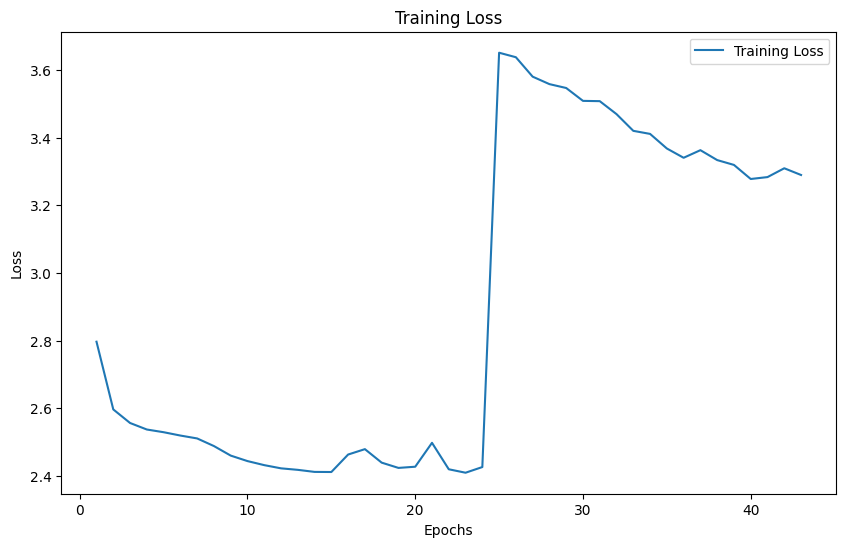

TypeError: list indices must be integers or slices, not str

<Figure size 700x700 with 0 Axes>

In [ ]:
BATCH_SIZE = 16
DECAY_RATE = 0.001
learning_rate = 1e-4
win_len = 250
feature_size = 148
patience = 20
num_epochs_1 = 100
num_epochs_2 = 300
depth = 6
model_name_list =  ["ViT"]
ce_criterion = nn.CrossEntropyLoss()
criterion = InfoNCELoss(temperature=1)

for model_name in model_name_list:
  model = load_unsupervised_model(task, model_name,win_len,feature_size,depth=depth)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  save_path = "/content/drive/MyDrive/DL_Sensing_Benchmark_OW/ExperimentLog/"\
                  +experiment+"/"+task+"_self_supervised_contrastive_simclr"\
                  +"/"+model_name+"/"
  if not os.path.exists(save_path):
    os.makedirs(save_path)

  # model, df1,df2 = train(model, unsupervised_train_loader, supervised_train_loader,supervised_val_loader,test_dataloader, num_epochs_1,num_epochs_2, learning_rate, criterion,ce_criterion, device, patience,save_path)
  model, df1 =unsupervised_train(model, unsupervised_train_loader, num_epochs_1, learning_rate, criterion, device, patience, save_path)


  fig_val_loss = plt.figure(figsize = (7,7))
  sn.lineplot(x= df1['Epochs'], y = df1['total_loss'])
  plt.show()
  fig_val_loss.savefig(save_path+"unsupervised_train_loss.png")

  fig_val_loss = plt.figure(figsize = (7,7))
  sn.lineplot(x= df1['Epochs'], y = df1['kl_loss'])
  plt.show()
  fig_val_loss.savefig(save_path+"unsupervised_kl_loss.png")

  fig_val_loss = plt.figure(figsize = (7,7))
  sn.lineplot(x= df1['Epochs'], y = df1['he_loss'])
  plt.show()
  fig_val_loss.savefig(save_path+"unsupervised_he_loss.png")

  fig_val_loss = plt.figure(figsize = (7,7))
  sn.lineplot(x= df1['Epochs'], y = df1['eh_loss'])
  plt.show()
  fig_val_loss.savefig(save_path+"unsupervised_eh_loss.png")

  fig_val_loss = plt.figure(figsize = (7,7))
  sn.lineplot(x= df1['Epochs'], y = df1['kde_loss'])
  plt.show()
  fig_val_loss.savefig(save_path+"unsupervised_kde_loss.png")

  df1.to_csv(save_path+"unsupervised_train_loss.csv")



In [ ]:
fig_val_loss = plt.figure(figsize = (7,7))
sn.lineplot(x= df1['Epochs'], y = df1['total_loss'])
plt.show()
fig_val_loss.savefig(save_path+"unsupervised_train_loss.png")

fig_val_loss = plt.figure(figsize = (7,7))
sn.lineplot(x= df1['Epochs'], y = df1['kl_loss'])
plt.show()
fig_val_loss.savefig(save_path+"unsupervised_kl_loss.png")

fig_val_loss = plt.figure(figsize = (7,7))
sn.lineplot(x= df1['Epochs'], y = df1['he_loss'])
plt.show()
fig_val_loss.savefig(save_path+"unsupervised_he_loss.png")

fig_val_loss = plt.figure(figsize = (7,7))
sn.lineplot(x= df1['Epochs'], y = df1['eh_loss'])
plt.show()
fig_val_loss.savefig(save_path+"unsupervised_eh_loss.png")

fig_val_loss = plt.figure(figsize = (7,7))
sn.lineplot(x= df1['Epochs'], y = df1['kde_loss'])
plt.show()
fig_val_loss.savefig(save_path+"unsupervised_kde_loss.png")

In [ ]:
BATCH_SIZE = 32
DECAY_RATE = 0.001
learning_rate = 1e-4
win_len = 250
feature_size = 148
patience = 20
num_epochs_1 = 100
num_epochs_2 = 300
depth = 6
model_name_list =  ["ViT"]
ce_criterion = nn.CrossEntropyLoss()
criterion = InfoNCELoss(temperature=1)

for model_name in model_name_list:
  model = load_unsupervised_model(task, model_name,win_len,feature_size,depth=depth)

checkpoint_path = save_path+"best_model_checkpoint_ssl.pth.tar"
model, start_epoch, last_loss = load_checkpoint(checkpoint_path, model)

model,df2 = train_supervised(model, supervised_train_loader, supervised_val_loader, test_dataloader, num_epochs_2, learning_rate, ce_criterion, device, optimizer_decay_rate = DECAY_RATE, patience=patience,save_path=save_path)

using model: ViT_Parrallel
925
Starting supervised training phase.
Epoch 1/300, Train Loss: 1.1656, Validation Loss: 1.1447
Epoch 2/300, Train Loss: 1.0412, Validation Loss: 0.8078
Epoch 3/300, Train Loss: 0.8740, Validation Loss: 0.7651
Epoch 4/300, Train Loss: 0.7421, Validation Loss: 0.6571
Epoch 5/300, Train Loss: 0.5889, Validation Loss: 0.4880
Epoch 6/300, Train Loss: 0.5388, Validation Loss: 0.4332
Epoch 7/300, Train Loss: 0.5060, Validation Loss: 0.6295
Epoch 8/300, Train Loss: 0.5484, Validation Loss: 0.5015
Epoch 9/300, Train Loss: 0.4925, Validation Loss: 0.4094
Epoch 10/300, Train Loss: 0.5092, Validation Loss: 0.3704
Epoch 11/300, Train Loss: 0.4659, Validation Loss: 0.4404
Epoch 12/300, Train Loss: 0.5878, Validation Loss: 0.5204
Epoch 13/300, Train Loss: 0.5557, Validation Loss: 0.4271
Epoch 14/300, Train Loss: 0.5100, Validation Loss: 0.4173
Epoch 15/300, Train Loss: 0.4922, Validation Loss: 0.6111
Epoch 16/300, Train Loss: 0.5148, Validation Loss: 0.3745
Epoch 17/300, 

In [ ]:
df_test = test(model, test_dataloader,task,save_path)



fig_val_loss = plt.figure(figsize = (7,7))
sn.lineplot(x= df2['Epochs'], y = df2['train_loss'])
plt.show()
fig_val_loss.savefig(save_path+"supervised_train_loss.png")

fig_val_loss = plt.figure(figsize = (7,7))
sn.lineplot(x= df2['Epochs'], y = df2['validation_loss'])
plt.show()
fig_val_loss.savefig(save_path+"supervised_validation_loss.png")


fig_val_loss = plt.figure(figsize = (7,7))
sn.lineplot(x= df2['Epochs'], y = df2['supervised_train_acc_1'])
plt.show()
fig_val_loss.savefig(save_path+"supervised_train_acc_1.png")

fig_val_loss = plt.figure(figsize = (7,7))
sn.lineplot(x= df2['Epochs'], y = df2['supervised_train_acc_2'])
plt.show()
fig_val_loss.savefig(save_path+"supervised_train_acc_2.png")


Test Accuracy: 71.05%


NameError: name 'df2' is not defined

<Figure size 700x700 with 0 Axes>

In [ ]:
task = 'FourClass'
data_dir = "/content/drive/MyDrive/DL_Sensing_Benchmark_OW/Data"
experiment = "1500_Intrusion_Eval"
BATCH_SIZE = 32


# get the class number of different task
classes = {'HumanNonhuman': 2, 'FourClass': 4, 'HumanID': 4, 'HumanMotion': 3, 'ThreeClass': 3}

# retrive the data
train_set = OW_dataset_class(data_dir, task, experiment, 0, 1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)





IRobot labeled
Pet labeled
Fan labeled
3
Human labeled
Pet labeled
Human labeled
IRobot labeled
Human labeled
IRobot labeled
IRobot labeled
Pet labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled
Human labeled


In [ ]:
mean = 0
std = 0

for x,y in train_loader:
    batch_samples = x.size(0) # batch size (the last batch can have smaller size!)
    x = x.view(batch_samples, x.size(1), -1)
    mean += x.mean(2).sum(0)
    std += x.std(2).sum(0)

mean /= len(train_loader.dataset)
std /= len(train_loader.dataset)

print(mean)
print(std)

tensor([-0.0064])
tensor([0.0217])


In [ ]:
# #######################################
# # self-supervised training
# print ('Self-supervised encoder training')
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=args.weight_decay)
# for epoch in range(100):
#         total_loss = 0
#         kl_loss = 0
#         eh_loss = 0
#         he_loss = 0
#         kde_loss = 0
#         for data in unsupervised_train_loader:
#                 x, y = data
#                 x, y = x.to(device), y.to(device)
#                 x1 = gaussian_noise(x, random.uniform(0, 2.0),win_len,feature_size)
#                 x2 = gaussian_noise(x, random.uniform(0.1, 2.0),win_len,feature_size)

#                 # ===================forward=====================
#                 feat_x1, feat_x2 = model(x1, x2)
#                 loss = criterion(feat_x1, feat_x2)
#                 loss_kl = loss['kl']
#                 loss_eh = loss['eh']
#                 loss_he = loss['he']
#                 loss_kde = loss['kde']
#                 loss = loss['final-kde']

#                 # ===================backward====================
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#                 # ===================log========================
#                 total_loss += loss.data
#                 kl_loss += loss_kl.data
#                 eh_loss += loss_eh.data
#                 he_loss += loss_he.data
#                 kde_loss += loss_kde.data
#         print('epoch [{}/{}], total loss:{:.4f},kl loss:{:.4f},eh loss:{:.4f},he loss:{:.4f},kde loss:{:.4f}'
#                 .format(epoch+1,100, total_loss, kl_loss, eh_loss, he_loss, kde_loss))
# #######################################

# #######################################
# # test
# def test():
#     model.eval()
#     correct_1, correct_2 = 0, 0
#     total = 0
#     with torch.no_grad():
#         for data in test_dataloader:
#             x, y = data
#             x, y = x.to(device), y.to(device)

#             y1, y2 = model(x, x, flag='supervised')
#             _, pred_1 = torch.max(y1.data, 1)
#             _, pred_2 = torch.max(y2.data, 1)
#             total += y.size(0)
#             correct_1 += (pred_1 == y).sum().item()
#             correct_2 += (pred_2 == y).sum().item()

#     print('Test accuracy: {:.2f}%, {:.2f}%'.format(100 * correct_1 / total, 100 * correct_2 / total))
# #######################################

# ##################################
# # supervised learning
# print ('Supervised classifier training')
# optimizer_supervised = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate, weight_decay=1e-5)


# for epoch in range(300):
#     model.train()
#     total_loss = 0
#     for data in supervised_train_loader:
#         x, y = data
#         x = Variable(x).to(device)
#         y = y.type(torch.LongTensor)
#         y = y.to(device)

#         # ===================forward=====================
#         y1, y2 = model(x, x, flag='supervised')
#         loss = ce_criterion(y1, y) + ce_criterion(y2, y)

#         # ===================backward====================
#         optimizer_supervised.zero_grad()
#         loss.backward()
#         optimizer_supervised.step()
#     # ===================log========================
#     total_loss += loss.data
#     print('epoch [{}/{}], loss:{:.6f}'
#         .format(epoch+1, 300, total_loss))
#     # test
#     if epoch > 250:
#         test()
# ##################################

